# ASE & CP2K

Set some environment variables for the notebook. For doing this on a HPC resource, these would be set as export commands in the slurm script. Also, the ASE_CP2K_COMMAND would change to "srun cp2k_shell.psmp"

In [2]:
%set_env SHELL=/bin/bash
%set_env OMP_NUM_THREADS=8
%set_env ASE_CP2K_COMMAND=/home/woodrowwilson/Programs/cp2k/9.1/exe/PopOS-x86-64-gfortran/cp2k_shell.ssmp

env: SHELL=/bin/bash
env: OMP_NUM_THREADS=8
env: ASE_CP2K_COMMAND=/home/woodrowwilson/Programs/cp2k/9.1/exe/PopOS-x86-64-gfortran/cp2k_shell.ssmp


I had to change two things with my installed copy of ASE. I had to manually add the plumed.py file from the GitLab repository, and I also had to change the cp2k.py file.

1. Go to ${HOME}/Programs/miniconda3/lib/python3.9/site-packages/ase/calculators
2. Copy the plumed.py file from the [GitLab Repository](https://gitlab.com/ase/ase/-/blob/master/ase/calculators/plumed.py) to this directory
3. Open the cp2k.py file
4. Edit the expect function so that it reads as follows

def expect(self, line):

         """Receive a line and asserts that it matches the expected one"""
       
         received = self.recv()
         if "VORONOI|" in received:
             while received != line:
                 received = self.recv()
         else:
             assert received == line

## Modules

In [3]:
# General
import os
import sys
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

# For building things
from ase import Atom, Atoms
from ase.io import read, write
from ase.io.trajectory import Trajectory
from ase.build import molecule
from ase.visualize import view

# Unit Conversions and Fixing Atoms
from ase.units import Bohr,Rydberg,kJ,kB,fs,Hartree,mol,kcal
from ase.constraints import FixedPlane, FixedLine, FixAtoms

# ASE Calculators
from plumed import Plumed
from ase.calculators.cp2k import CP2K
from ase.calculators.lj import LennardJones
from ase.calculators.plumed import Plumed
from ase.calculators.idealgas import IdealGas

# Geometry Optimizations and Normal Mode Analysis
from ase.optimize import LBFGS, FIRE
from ase.vibrations import Vibrations
from ase.thermochemistry import IdealGasThermo

# EOS fitting for Unit Cells
from ase.eos import EquationOfState

# Molecular Dynamics
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution
from ase.md.verlet import VelocityVerlet
from ase.md.langevin import Langevin
from ase.md.npt import NPT

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


Sets the current working directory

In [4]:
cwd = os.getcwd()
cwd

'/home/woodrowwilson/Documents/Projects/sandbox'

The beauty of using CP2K within ASE is that you can directly go from building a system, to running a calculation. The calculator object simply calculates the energy as a function of the coordinates, while ASE handles updating the positions of the particles. For these first few examples, we will just be performing DFT calculations on a single water molecule.

In [5]:
atoms = molecule("H2O")

#atoms.set_cell([8, 8, 8, 90, 90, 90])
#atoms.center()

atoms.center(vacuum=2.0)

atoms.set_pbc(True)

view(atoms, viewer="ngl")

This isn a custom function that I wrote for creating the CP2K calculator object. It augments the default CP2K input file that ASE would normally generate with these keywords.

In [6]:
def myCP2KCalculator(tag, functional, ecut):
    """Creates a CP2K calculator object with Settings for Production Runs
    tag -> label for cp2k output
    functional -> Either PBE+D3, BEEFVDW, rVV10, or LDA+FermiDirac
    ecut -> PW Kinetic Energy Cutoff (Rydberg)
    """
    
    if functional == "PBE+D3":
        xc = "PBE"
        inp = '''
&GLOBAL
  WALLTIME 47:58:00
&END GLOBAL
&FORCE_EVAL
  &DFT
    SURFACE_DIPOLE_CORRECTION .FALSE.
    SURF_DIP_DIR Z
    &SCF
      &OT .TRUE.
        MINIMIZER DIIS
        PRECONDITIONER FULL_SINGLE_INVERSE
      &END OT
      &OUTER_SCF .TRUE.
        MAX_SCF 50
      &END OUTER_SCF
    &END SCF
    &XC
      &VDW_POTENTIAL
        POTENTIAL_TYPE PAIR_POTENTIAL
        &PAIR_POTENTIAL
          R_CUTOFF 15.0
          TYPE DFTD3
          CALCULATE_C9_TERM .FALSE.
          REFERENCE_FUNCTIONAL PBE
          PARAMETER_FILE_NAME dftd3.dat
        &END PAIR_POTENTIAL
      &END VDW_POTENTIAL
      &XC_GRID
        XC_DERIV NN10_SMOOTH
        XC_SMOOTH_RHO NN10
      &END
    &END XC
    &PRINT
      &E_DENSITY_BQB OFF
      &END E_DENSITY_BQB
      &VORONOI OFF
          OUTPUT_TEXT .TRUE.
      &END VORONOI
    &END PRINT
  &END DFT
&END FORCE_EVAL
'''
    elif functional == "BEEFVDW":
        xc = "GGA_XC_BEEFVDW"
        inp = '''
&GLOBAL
  WALLTIME 47:58:00
&END GLOBAL
&FORCE_EVAL
  &DFT
    SURFACE_DIPOLE_CORRECTION .FALSE.
    SURF_DIP_DIR Z
    &SCF
      &OT .TRUE.
        MINIMIZER DIIS
        PRECONDITIONER FULL_SINGLE_INVERSE
      &END OT
      &OUTER_SCF .TRUE.
        MAX_SCF 50
      &END OUTER_SCF
    &END SCF
    &XC
      &XC_GRID
        XC_DERIV NN10_SMOOTH
        XC_SMOOTH_RHO NN10
      &END
      &VDW_POTENTIAL
          &NON_LOCAL
              TYPE LMKLL
              KERNEL_FILE_NAME vdW_kernel_table.dat
          &END NON_LOCAL
      &END VDW_POTENTIAL
    &END XC
    &PRINT
      &E_DENSITY_BQB OFF
      &END E_DENSITY_BQB
      &VORONOI ON
          OUTPUT_TEXT .TRUE.
      &END VORONOI
    &END PRINT
  &END DFT
&END FORCE_EVAL
'''
    elif functional == "rVV10":
        xc = None
        inp = '''
&GLOBAL
  WALLTIME 47:58:00
&END GLOBAL
&FORCE_EVAL
  &DFT
    SURFACE_DIPOLE_CORRECTION .FALSE.
    SURF_DIP_DIR Z
    &SCF
      &OT .TRUE.
        MINIMIZER DIIS
        PRECONDITIONER FULL_SINGLE_INVERSE
      &END OT
      &OUTER_SCF .TRUE.
        MAX_SCF 50
      &END OUTER_SCF
    &END SCF
    &XC
       &XC_FUNCTIONAL
         &GGA_X_RPW86
         &END GGA_X_RPW86
         &GGA_C_PBE
         &END GGA_C_PBE
       &END XC_FUNCTIONAL
       &vdW_POTENTIAL
          DISPERSION_FUNCTIONAL NON_LOCAL
          &NON_LOCAL
            TYPE RVV10
            PARAMETERS 6.3 0.0093
            VERBOSE_OUTPUT
            KERNEL_FILE_NAME rVV10_kernel_table.dat
            CUTOFF 40
          &END NON_LOCAL
       &END vdW_POTENTIAL
      &XC_GRID
        XC_DERIV NN10_SMOOTH
        XC_SMOOTH_RHO NN10
      &END
    &END XC
    &PRINT
      &E_DENSITY_BQB OFF
      &END E_DENSITY_BQB
      &VORONOI ON
          OUTPUT_TEXT .TRUE.
      &END VORONOI
    &END PRINT
  &END DFT
&END FORCE_EVAL
'''
    elif functional == "LDA+FermiDirac":
        xc = "LDA"
        inp = '''
&GLOBAL
  WALLTIME 47:58:00
&END GLOBAL
&FORCE_EVAL
  &DFT
    SURFACE_DIPOLE_CORRECTION .FALSE.
    SURF_DIP_DIR Z
    &KPOINTS
        SCHEME MONKHORST-PACK 6 6 6
    &END KPOINTS
    &SCF
      ADDED_MOS 10
      &SMEAR ON
          METHOD FERMI_DIRAC
          ELECTRONIC_TEMPERATURE [K] 300
      &END SMEAR
      &MIXING .TRUE.
          METHOD BROYDEN_MIXING
      &END MIXING
      &OUTER_SCF .TRUE.
        MAX_SCF 50
      &END OUTER_SCF
    &END SCF
    &XC
      &XC_GRID
        XC_DERIV NN10_SMOOTH
        XC_SMOOTH_RHO NN10
      &END
    &END XC
    &PRINT
      &E_DENSITY_BQB OFF
      &END E_DENSITY_BQB
      &VORONOI OFF
          OUTPUT_EMP .TRUE.
      &END VORONOI
    &END PRINT
  &END DFT
&END FORCE_EVAL
'''
    else:
        xc = "LDA"
        inp = ''''''
        
    calc = CP2K(
        auto_write=False,
        basis_set="DZVP-MOLOPT-SR-GTH",
        basis_set_file="BASIS_MOLOPT",
        charge=0,
        cutoff = ecut*Rydberg,
        debug = False,
        force_eval_method = "Quickstep",
        xc = xc,
        inp = inp,
        max_scf = 50,
        poisson_solver ="auto",
        potential_file = "POTENTIAL",
        pseudo_potential = "GTH-PBE",
        stress_tensor = True,
        print_level = "LOW",
        label = tag,
    )
    return calc

## Minimization

Now that we have our system and how we are going to calculate energies defined, we can jump into the calculations. These cells are structured so that a directory will be made and then the calculation will run. The Fast Inertial Relaxation Engine or (FIRE)[https://link.aps.org/doi/10.1103/PhysRevLett.97.170201] minimizes the structure with molecular dynamics. Other Quasi-Newton algorithms are also available instead with a similar interface.

In [7]:
dirname = "minimization"
if not os.path.isdir(dirname):
    os.mkdir(dirname)
else:
    pass
os.chdir(dirname)

atoms.calc = myCP2KCalculator(dirname, "PBE+D3", 450.0)

minimizer = FIRE(atoms, trajectory="fire.traj", logfile="fire.log")
minimizer.run(fmax=0.03)
potentialenergy = atoms.get_potential_energy()

os.chdir(cwd)


## Normal Mode Analysis

In [8]:
dirname = "vibrations"
if not os.path.isdir(dirname):
    os.mkdir(dirname)
else:
    pass
os.chdir(dirname)

atoms.calc = myCP2KCalculator(dirname, "PBE+D3", 450.0)

vib = Vibrations(atoms)
vib.run()
vib_energies = vib.get_energies()

os.chdir(cwd)

In [9]:
thermo = IdealGasThermo(vib_energies=vib_energies,
                        potentialenergy=potentialenergy,
                        atoms=atoms,
                        geometry='nonlinear',
                        symmetrynumber=2, spin=0)
G = thermo.get_gibbs_energy(temperature=298.15, pressure=101325.)

Enthalpy components at T = 298.15 K:
E_pot               -467.721 eV
E_ZPE                  0.568 eV
Cv_trans (0->T)        0.039 eV
Cv_rot (0->T)          0.039 eV
Cv_vib (0->T)          0.000 eV
(C_v -> C_p)           0.026 eV
-------------------------------
H                   -467.050 eV

Entropy components at T = 298.15 K and P = 101325.0 Pa:
                           S               T*S
S_trans (1 bar)    0.0015019 eV/K        0.448 eV
S_rot              0.0004572 eV/K        0.136 eV
S_elec             0.0000000 eV/K        0.000 eV
S_vib              0.0000003 eV/K        0.000 eV
S (1 bar -> P)    -0.0000011 eV/K       -0.000 eV
-------------------------------------------------
S                  0.0019583 eV/K        0.584 eV

Free energy components at T = 298.15 K and P = 101325.0 Pa:
    H       -467.050 eV
 -T*S         -0.584 eV
-----------------------
    G       -467.634 eV


## NVT Molecular Dynamics

ASE comes with several integrators for Newton's equations of motions. The most robust one for the canonical ensemble is the Langevin thermostat. 

In [10]:
dirname = "nvt"
if not os.path.isdir(dirname):
    os.mkdir(dirname)
else:
    pass
os.chdir(dirname)

MaxwellBoltzmannDistribution(atoms, temperature_K=300)

atoms.calc = myCP2KCalculator(dirname, "PBE+D3", 450.0)

md = Langevin(atoms, 0.5*fs, temperature_K = 300.0, friction=0.01, 
              trajectory="langevin.traj", logfile='langevin.log')

md.run(200)

os.chdir(cwd)

## Unit Cell Equation of State Fitting

For finding optimal lattice vectors, ASE can calculate the equation of state for a unit cell.

In [11]:
atoms = read("Resources/cif/beta-Mo2C_mp-1221498_conventional_standard.cif")
view(atoms, viewer = "ngl")

In [12]:
dirname = "uc-eos"
if not os.path.isdir(dirname):
    os.mkdir(dirname)
else:
    pass
os.chdir(dirname)

atoms.calc = myCP2KCalculator(dirname, "LDA+FermiDirac", 450.0)

cell = atoms.get_cell()
traj = Trajectory('eos.traj', 'w')
for x in np.linspace(0.95, 1.05, 5):
    print(cell * x)
    atoms.set_cell(cell * x, scale_atoms=True)
    atoms.get_potential_energy()
    traj.write(atoms)

os.chdir(cwd)

[[ 2.91944646  0.          0.        ]
 [-1.45972323  2.5283148   0.        ]
 [ 0.          0.          4.41991057]]
[[ 2.996274   0.         0.       ]
 [-1.498137   2.5948494  0.       ]
 [ 0.         0.         4.536224 ]]
[[ 3.07310154  0.          0.        ]
 [-1.53655077  2.661384    0.        ]
 [ 0.          0.          4.65253744]]
[[ 3.14992908  0.          0.        ]
 [-1.57496454  2.7279186   0.        ]
 [ 0.          0.          4.76885088]]
[[ 3.22675662  0.          0.        ]
 [-1.61337831  2.7944532   0.        ]
 [ 0.          0.          4.88516431]]


Bulk Modulus [GPa]: 271.1278927277926


<AxesSubplot:title={'center':'sj: E: -3861.696 eV, V: 36.877 Å$^3$, B: 271.128 GPa'}, xlabel='volume [Å$^3$]', ylabel='energy [eV]'>

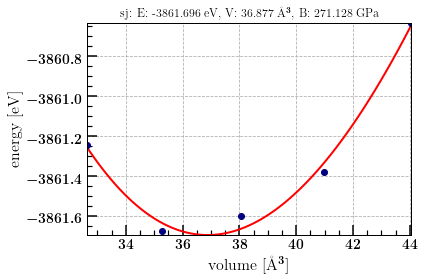

In [14]:
os.chdir(cwd)
configs = read('uc-eos/eos.traj@0:5')  # read 5 configurations
# Extract volumes and energies:
volumes = [atoms.get_volume() for atoms in configs]
energies = [atoms.get_potential_energy() for atoms in configs]
eos = EquationOfState(volumes, energies)
v0, e0, B = eos.fit()
print("Bulk Modulus [GPa]:", B / kJ * 1.0e24)
eos.plot()

## Metadynamics

### Simple metadynamics of a LJ Particles on a Plane

This tutorial is originally from https://gitlab.com/Sucerquia/ase-plumed_tutorial#planar-7-atoms-cluster. In principle, the calculator set inside of the Plumed calculator can be any calculator, not just for Lennard Jones, but also with CP2K!